# Quantum Simulation of a discrete Heston Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

# importing Qiskit
import qiskit
from qiskit import *

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector

aer_sim = Aer.get_backend('aer_simulator')

## 1. Defining the algorithm operator

In this section, we define the quantum operator for a simplified Heston model with explicit encoding of the distribution. This can be found in Appendix B of the paper Vazquez/Woerner: "Efficient State Preparation for Quantum Amplitude Estimation", 2020.

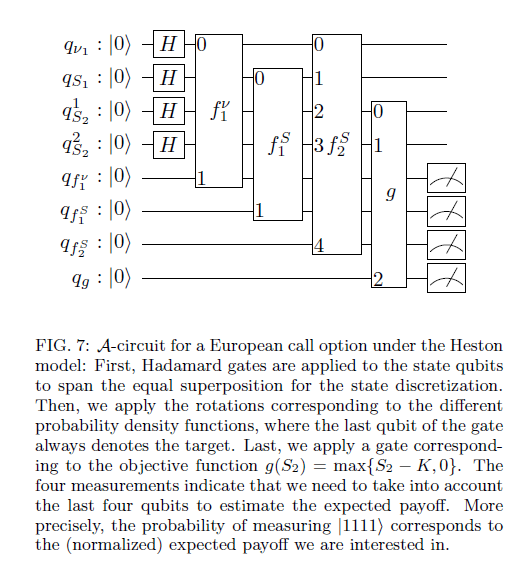

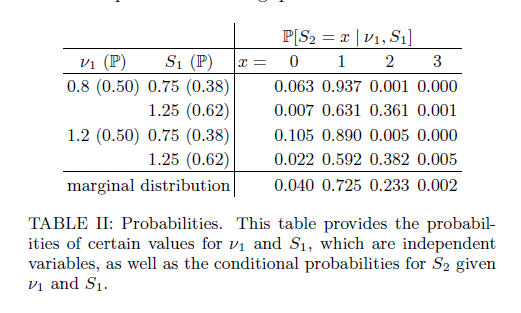

In [2]:
# Define probabilities
# Note that Table II includes roundings, hence we have adjusted
# the last probability (P(S2=3|S1=1.25)), such that the marginal probabilities for S2 sum to one.
probs = {'v': [0.5, 0.5],
         's1': [0.38, 0.62],
        's2': [[0.063, 0.937, 0.001, 0.0], 
               [0.007, 0.631, 0.361, 0.001],
               [0.105, 0.890, 0.005, 0.0],
               [0.022, 0.592, 0.382, 0.00338709677419331]]}
agl = lambda x: 2 * np.arcsin(np.sqrt(x))
angles = {'v': [agl(x) for x in probs.get('v')],
         's1': [agl(x) for x in probs.get('s1')],
         's2': [[agl(x) for x in y] for y in probs.get('s2')],}
#print(angles.get('s2'))

In [3]:
# Helper functions
def xif(qc, q, c):
    if c == 0:
        qc.x(q)
        
def mcry(theta, nControls):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc = qc.to_gate()
    qc.label = "mcry(" + str(round(100*theta)/100) + ")"
    cqc = qc.control(nControls)
    return cqc

def barrif(qc, b):
    if b:
        qc.barrier()


In [4]:
# Rotations on the ancilla qubits to generate distribution and payoff function
def vRot(withBarrier = False):
    qc = QuantumCircuit(8)
    for q in range(2):
        xif(qc, 0, q)
        qc.cry(angles.get('v')[q], 0, 4)
        xif(qc, 0, q)
        barrif(qc, withBarrier)
    return qc
        
def s1Rot(withBarrier = False):
    qc = QuantumCircuit(8)
    for q in range(2):
        xif(qc, 1, q)
        qc.cry(angles.get('s1')[q], 1, 5)
        xif(qc, 1, q)
        barrif(qc, withBarrier)
    return qc

def s2Rot(withBarrier = False):
    qc = QuantumCircuit(8)
    crs = [(x,y) for x in range(2) for y in range(2)]
    for (v, s1) in crs:
        for (q1, q2) in crs:
            row = 2 * v + s1
            col = 2 * q1 + q2
            xif(qc, 0, v)
            xif(qc, 1, s1)
            xif(qc, 2, q1)
            xif(qc, 3, q2)
            qc.append(mcry(angles.get('s2')[row][col], 4), [0, 1, 2, 3, 6])
            xif(qc, 3, q2)
            xif(qc, 2, q1)
            xif(qc, 1, s1)
            xif(qc, 0, v)
            barrif(qc, withBarrier)
    return qc

def gRot(withBarrier = False):
    # Controlled rotation for the payoff function
    # g(S2) = max(0, S2 - 1), which is normalized to 0.5 * g(S2) \in [0,1]
    # More precisely g(0) = g(1) = 0, g(2) = 0.5, g(3) = 1
    # In our encoding, 0 = 00, 1 = 01, 2 = 10, 3 = 11, 
    # hence we require a rotation by pi/2 if q1=1 and another pi/2 if q2=1
    qc = QuantumCircuit(8)
    qc.cry(0.5 * math.pi, 2, 7)
    qc.append(mcry(0.5 * math.pi, 2), [2, 3, 7])
    barrif(qc, withBarrier)
    return qc


In [5]:
# Build the algorithm operator 
def woernerA(toGate = True):
    qc = QuantumCircuit(8)
    # Hadamard for uniform superposition
    qc.h(range(4))
    # Controlled rotation for v ancilla
    qc = qc.compose(vRot(not toGate))
    # Controlled rotation for s1 ancilla
    qc = qc.compose(s1Rot(not toGate))
    # Controlled rotation for s2 ancilla
    qc = qc.compose(s2Rot(not toGate))
    # Controlled rotation for the payoff function
    qc = qc.compose(gRot(not toGate))
    if toGate:
        qc = qc.to_gate()
    qc.label = "A"
    return qc

In [6]:
a = woernerA(False)
#a.draw()

In [7]:
qc_test = QuantumCircuit(8, 4)
qc_test.append(woernerA(), range(8))
#qc = qc.compose(woernerA(False))
qc_test.measure([4, 5, 6 ,7], range(4))
qc_test.draw()

┌────┐            
q_0: ┤0   ├────────────
     │    │            
q_1: ┤1   ├────────────
     │    │            
q_2: ┤2   ├────────────
     │    │            
q_3: ┤3   ├────────────
     │  A │┌─┐         
q_4: ┤4   ├┤M├─────────
     │    │└╥┘┌─┐      
q_5: ┤5   ├─╫─┤M├──────
     │    │ ║ └╥┘┌─┐   
q_6: ┤6   ├─╫──╫─┤M├───
     │    │ ║  ║ └╥┘┌─┐
q_7: ┤7   ├─╫──╫──╫─┤M├
     └────┘ ║  ║  ║ └╥┘
c: 4/═══════╩══╩══╩══╩═
            0  1  2  3

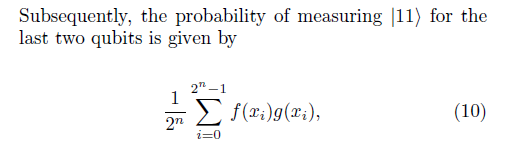

## 2. Testing the PV by direct simulation

The exact (normalized) PV is given by the marginal distributions for S2 in Table II above times the payoff:

In [8]:
mp2 = probs['v'][0]*(probs['s1'][0]*probs['s2'][0][2] + probs['s1'][1]*probs['s2'][1][2])
mp2 = mp2 + probs['v'][1]*(probs['s1'][0]*probs['s2'][2][2] + probs['s1'][1]*probs['s2'][3][2])
mp3 = probs['v'][0]*(probs['s1'][0]*probs['s2'][0][3] + probs['s1'][1]*probs['s2'][1][3])
mp3 = mp3 + probs['v'][1]*(probs['s1'][0]*probs['s2'][2][3] + probs['s1'][1]*probs['s2'][3][3])
po2 = 0.5
po3 = 1.0
pv_exact = mp2*po2 + mp3*po3
print('Exact PV = ' + str(pv_exact))

Exact PV = 0.11709499999999994


We can test the PV by direct simulation and counting good states. This is equivalent to classical simulation with $1/\sqrt{shots}$ convergence:

In [9]:
# Calculate PV by direct simulation, i.e. measuring fraction of "good" states
# Note: This is equivalent to classical MC with 1/sqrt(shots) convergence
t_qc_test = transpile(qc_test, aer_sim)
qobj_test = assemble(t_qc_test)
shots = 10000
job_test = aer_sim.run(qobj_test, shots = shots)
hist_test = job_test.result().get_counts()
pv_test = (2**4) * hist_test.get('1111')/shots # see formula above for the prefactor 2^4
print('Expected payoff = ' + str(pv_test))

Expected payoff = 0.1088


## 3.  Calculating the PV by Quantum Amplitude Estimation


In this section, we calculate the PV (i.e. the probability of measuring a good state of the algorithm operator) by quantum amplitude estimation as described in the paper Brassard et al: Quantum Amplitude Amplification and Estimation, 2000. This in principle has an improved convergence of $1/shots$.

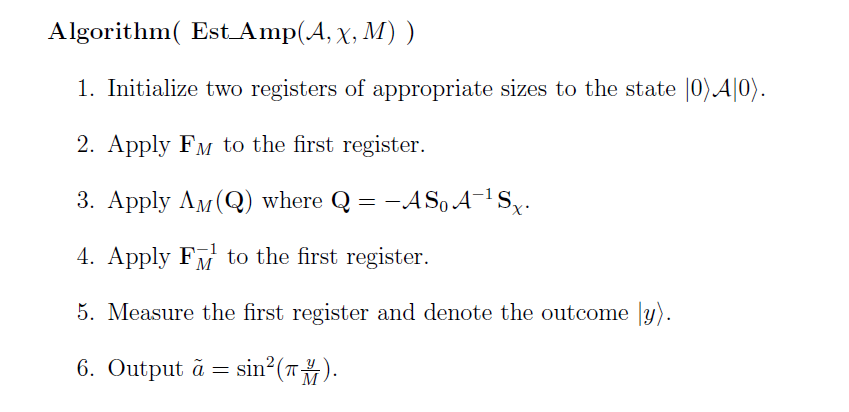

In [10]:
# Define sign flip operator for "good" states
# Note: good state is |1111>
def Sx():
    qc = QuantumCircuit(8)
    # Do multi-controlled-Z gate
    qc.h(7)
    qc.mct(list(range(4,7)), 7)  # multi-controlled-toffoli
    qc.h(7)
    qc = qc.to_gate()
    qc.label = "S1"
    return qc

In [11]:
# Define sign flip operator for zero state
def S0():
    qc = QuantumCircuit(8)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(8):
        qc.x(qubit)
    qc.h(7)
    qc.mct(list(range(7)), 7)  # multi-controlled-toffoli (converting |-> to -|->)
    qc.h(7)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(8):
        qc.x(qubit)
    qc = qc.to_gate()
    qc.label = "S0"
    return qc

In [12]:
# Define operator Q
# Note: We actually define -Q = +A S0 AT S1 instead of Q, i.e. we measure the amplitude of "bad states"
def Q():
    A = woernerA()
    AT = A.inverse()
    AT.label = "A†"
    qc = QuantumCircuit(8)
    qc.append(Sx(), range(8))
    qc.append(AT, range(8))
    qc.append(S0(), range(8))
    qc.append(A, range(8))
    qc.label = "-Q"
    return qc
    
    

In [13]:
# Define QFT (from Qiskit notebook "Quantum Counting")
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


In [14]:
# Build the QAE circuit
def qcQAE(t, n):
    qc_amp = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

    # Apply Hadamard to counting register
    for qubit in range(t):
        qc_amp.h(qubit)
    #qc.append(qft(4).to_gate(), range(t))

    # Apply A operator to algo register
    qc_amp.append(woernerA(),range(t, n+t))

    # Apply controlled Q operators
    cQ = Q().to_gate()
    cQ.label = "Q"
    cQ = cQ.control()
    iterations = 1
    for qubit in range(t):
        for i in range(iterations):
            qc_amp.append(cQ, [qubit] + [*range(t, n+t)])
        iterations *= 2

    # Do inverse QFT on counting qubits
    qft_dagger = qft(t).to_gate().inverse()
    qft_dagger.label = "QFT†"
    qc_amp.append(qft_dagger, range(t))

    # Measure counting qubits
    qc_amp.measure(range(t), range(t))
    return qc_amp

In [15]:
# Note: We expect pv = 0.1171. We have 16*sin(pi/32)^2 = 0.6 and 16*sin(pi/64)^2=0.15.
# Hence we need at least 5 counting qubits to get a pv different from zero
t = 5   # no. of counting qubits
n = 8   # no. of algo qubits
qc_amp = qcQAE(t, n)
#qc_amp.draw()

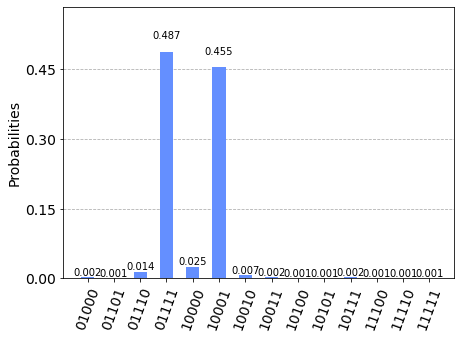

In [16]:
# Calculate PV by amplitude estimation
# Note: This provides quantum speed-up with 1/shots convergence
tic = time.time()
transpiled_qc_amp = transpile(qc_amp, aer_sim)
qobj_amp = assemble(transpiled_qc_amp)
shots=1000
job_amp = aer_sim.run(qobj_amp, shots=shots)
hist_amp = job_amp.result().get_counts()
toc = time.time()
plot_histogram(hist_amp)

In [17]:
# Extract the result
measured_str = max(hist_amp, key=hist_amp.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**t))*math.pi
print("Theta = %.5f" % theta)
pv = (1-(math.sin(theta)**2))*2**4 # recall that we measure amplitude of bad states, hence the "1-a"
print("PV = %.5f" % pv)

Register Output = 15
Theta = 1.47262
PV = 0.15372


This is the expected result of 0.1537, i.e. the value closest to 0.1171 on 5 bits.

In [18]:
print("CPU Time = %.5f" % (toc-tic))

CPU Time = 44.25083


This is the expected result, i.e. the value on 5 counting qubits that is closest to the value of 0.1171 from Section 2 

## 4. Calculating the PV by Iterative Phase Estimation

This section uses iterative phase estimation (according to Qiskit textbook, Lab 4) to calculate the PV. Unlike in QAE, the bits of the phase are estimated subsequently in IPE, beginning with the least significant bit. In each step, the measured phase is corrected for the already known classical bits by a Z rotation.

The advantage of this approach is that it requires only a SINGLE counting qubit and hence significantly less of (currently) scarce qubit resources.

A disadvantage is that (unlike QAE) it cannot be parallelized. However, as the computation is dominated by the term $\mathcal{Q}^{2^n}$ and as $\sum_{n=0}^n 2^k = 2^{n+1}$, the time overhead is only around a factor 2 (indepedent of $n$).

As we need fewer qubits (9 versus at least 13 in QAE), we consider a higher accuracy of 7 classical bits here.

In [19]:
def qcIPE(classicalBits, countingQuBits, algoQuBits):
    q = QuantumRegister(countingQuBits + algoQuBits)
    c = ClassicalRegister(classicalBits)

    ##1 Initialization
    qc_ipe = QuantumCircuit(q,c)
    # Apply Hadamard to ancilla qubits
    qc_ipe.h(0)
    # Apply A operator to algo register
    qc_ipe.append(woernerA(),range(countingQuBits, countingQuBits+algoQuBits))

    # Define controlled Q operators
    cQ = Q().to_gate()
    cQ.label = "Q"
    cQ = cQ.control()

    # Loop over bits to determine
    for b in range(classicalBits-1,-1,-1):
        ##2 Apply control-U operator
        for i in range(2**b):
            qc_ipe.append(cQ, [0] + [*range(countingQuBits, countingQuBits+algoQuBits)])
        ##3 Apply phase correction
        for j in range(1,classicalBits-b):
            qc_ipe.rz(-np.pi/2**(classicalBits-b-j), 0).c_if(c[j-1], 1)
        ##4 measure the anscillar qubit in x-basis
        qc_ipe.h(0)
        qc_ipe.measure(q[0], c[classicalBits-1-b])
        ##5 reset the ancilla qubit
        qc_ipe.reset(q[0])
        qc_ipe.h(0)
    return qc_ipe


In [20]:
classicalBits = 7
countingQuBits = 1
algoQuBits = 8

qc_ipe = qcIPE(classicalBits, countingQuBits, algoQuBits)

#qc_ipe.draw()

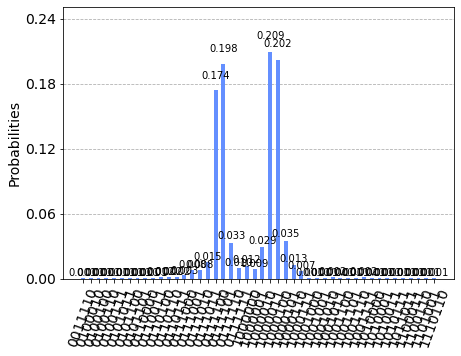

In [21]:
tic2 = time.time()
transpiled_qc_ipe = transpile(qc_ipe, aer_sim)
#qobj_ipe = assemble(transpiled_qc_ipe)
shots=1000
job_ipe = aer_sim.run(transpiled_qc_ipe, shots=shots)
hist_ipe = job_ipe.result().get_counts()
toc2 = time.time()
plot_histogram(hist_ipe)

In [22]:
# Extract the result
measured_str = max(hist_ipe, key=hist_ipe.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)
theta = (measured_int/(2**classicalBits))*math.pi
print("Theta = %.5f" % theta)
pv = (1-(math.sin(theta)**2))*2**4 # recall that we measure amplitude of bad states, hence the "1-a"
print("PV = %.5f" % pv)

Register Output = 67
Theta = 1.64443
PV = 0.08659


This is the expected result of 0.0866, i.e. the value closest to 0.1171 on 7 bits (actually closer than 0.1537 from the 5 bit case)

In [23]:
print("CPU Time = %.5f" % (toc2-tic2))

CPU Time = 534.24044


## 5. Qiskit built-in Amplitude Estimation

This section uses the built-in amplitude estimation algorithms as described in the Amplitude Estimation tutorial in Qiskit-Finance rather than the implementation from scratch in Sections 3 and 4

In [24]:
from qiskit.utils import QuantumInstance
quantum_instance = QuantumInstance(aer_sim)

In [25]:
from qiskit.algorithms import EstimationProblem

def get_problem():
    return EstimationProblem(
        state_preparation=woernerA(False),  # A operator
        grover_operator=Q(),  # Q operator
        objective_qubits=[4,5,6,7],  # the "bad" state Psi1 is identified as measuring |1111> in qubits 4-7
)

### 5.1 Canonical Amplitude Estimation

This is a built-in version of the algorithm in Section 3. The only parameter is the number of counting qubits to be used

In [38]:
from qiskit.algorithms import AmplitudeEstimation

def get_ae(num_eval_qubits):
    ae = AmplitudeEstimation(
        num_eval_qubits=num_eval_qubits,  # the number of evaluation qubits specifies circuit width and accuracy
        quantum_instance=quantum_instance,)

    return ae.estimate(get_problem())

The built-in algorithms already convert the result to a probability. Hence all we need to do is transform the bad-state to a good-state probability and remove the scaling from the algorithm operator

In [39]:
tic = time.time()
res_ae5 = get_ae(5)
pv_ae5 = (1-res_ae5.estimation)*(2**4)
toc = time.time()
print("PV AE = %.5f, CPUTime = %.5f" % (pv_ae5, toc-tic))

PV AE = 0.15372, CPUTime = 117.68102


This result corresponds to the canonical estimation with five counting qubits in Section 3. Note however that CPU time is three times longer here than in the from-scratch implementation in Section 3.

In [40]:
tic = time.time()
res_ae7 = get_ae(7)
pv_ae7 = (1-res_ae7.estimation)*(2**4)
toc = time.time()
print("PV AE = %.5f, CPUTime = %.5f" % (pv_ae7, toc-tic))

PV AE = 0.08659, CPUTime = 496.51029


This result corresponds to the iterative estimation with seven counting qubits in Section 4. The CPU time is is of the same order as the from-scratch implementation in Section 4.

### 5.2 Iterative Amplitude Estimation

This algorithm, which is not to be confused with the iterative phase estimation in Section 4, is based on the paper Grinco et al., "Iterative Quantum Amplitude Estimation", 2019. It uses a sophisticated application of Grover operators. Parameters are target accuarcy and probability of the confidence interval. Hence one does not need to think about the number of counting qubits to use.

In [41]:
from qiskit.algorithms import IterativeAmplitudeEstimation

def get_iae(epsilon_target, alpha):
    iae = IterativeAmplitudeEstimation(
        epsilon_target=epsilon_target,  # target accuracy
        alpha=alpha,  # width of the confidence interval
        quantum_instance=quantum_instance,)
    return iae.estimate(get_problem())



In [42]:
tic = time.time()
res_iae = get_iae(0.01, 0.05)
pv_iae = (1-res_iae.estimation)*(2**4)
toc = time.time()
print("PV IAE = %.5f, CPUTime = %.5f" % (pv_iae, toc-tic))

PV IAE = 15.88296, CPUTime = 43.30356


This result should correspond to the result in Section 3, but it deviates by one order of magnitude. When we consider prob instead of 1-prob, then we obtain almost the exact value of the PV:

In [55]:
pv_iae_prob = res_iae.estimation*(2**4)
print('Exact PV = ' + str(pv_exact))
print("PV IAE = %.5f" % (pv_iae_prob))

Exact PV = 0.11709499999999994
PV IAE = 0.11704


It is not obvious why the sign of the Q-operator is handled differently in canconical and iterative amplitude estimation. This requires further investigation

### 5.3 Max-Likelyhood Amplitude Estimation

Based on the paper Suzuki et al., "Amplitude Estimation without Phase Estimation", 2019

In [44]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

def get_mlae(evaluation_schedule):
    mlae = MaximumLikelihoodAmplitudeEstimation(
        evaluation_schedule=evaluation_schedule, # log2 of the maximal Grover power
        quantum_instance=quantum_instance  )
    return mlae.estimate(get_problem())


In [45]:
tic = time.time()
res_mlae = get_mlae(3)
pv_mlae = (1-res_mlae.estimation)*(2**4)
toc = time.time()
print("PV MLAE = %.5f, CPUTime = %.5f" % (pv_mlae, toc-tic))

PV MLAE = 15.88060, CPUTime = 58.20927


Same behavior of the sign of the Q-operator as in Section 5.2:

In [59]:
pv_mlae_prob = res_mlae.estimation*(2**4)
print('Exact PV = ' + str(pv_exact))
print("PV MLAE = %.5f" % (pv_mlae_prob))

Exact PV = 0.11709499999999994
PV MLAE = 0.11940


### 5.3 Faster Amplitude Estimation

Based on the paper Nakaji, "Faster Amplitude Estimation", 2020.

In [46]:
from qiskit.algorithms import FasterAmplitudeEstimation

def get_fae(delta, maxiter):
    fae = FasterAmplitudeEstimation(
        delta=delta,  # target accuracy
        maxiter=maxiter,  # determines the maximal power of the Grover operator
        rescale=False,
        quantum_instance=quantum_instance,)
    return fae.estimate(get_problem())


In [47]:
tic = time.time()
res_fae = get_fae(0.01, 3)
pv_fae = (1-res_fae.estimation)*(2**4) # recall that we measure amplitude of bad states, hence the "1-a"
toc = time.time()
print("PV FAE = %.5f, CPUTime = %.5f" % (pv_fae, toc-tic))

PV FAE = 15.88081, CPUTime = 54.02286


Same behavior of the sign of the Q-operator as in Section 5.2:

In [58]:
pv_fae_prob = res_fae.estimation*(2**4)
print('Exact PV = ' + str(pv_exact))
print("PV FAE = %.5f" % (pv_fae_prob))

Exact PV = 0.11709499999999994
PV FAE = 0.11919


## 6. Remarks

a) The explicit encoding of the distribution is preventing any quantum speed-up here. As mentioned in Vazquez/Woerner, the distribution needs to be encoded by quantum arithmetics

b) The spin-echo circuit optimization as described in Sectin 4 of that paper is also not implemented yet.
